# Restore Ecosystems

This notebook outlines the general workflow for the data within the [Restore Ecosystems](oceancentral.org/track/restore-ecosystems) page of the Ocean Central website.

Unless otherwise noted, all polygonal calculations were done in the Mollweide Projection (ESRI:54009)

## Total Area Tags (0)

Data processing for this figure was done in QGIS. The following are relevant notes to the process.

1. For those polygons with incorrect geometries, the geometries were corrected with the `Fix Geometries` method.
2. Ecosystems were `dissolved` into a single shape to remove double counting due to overlaps.
3. Area was summed across all polygons

## Ecosystem Time Series (1)

Time series data is currently only available for the mangrove ecosystem.

Data can be found through [Global Mangrove Watch](https://zenodo.org/records/6894273/files/gmw_v3_country_statistics_ha.xlsx?download=1).

This particular chart was generated with the values at the bottom of the "Country Extent" tab.

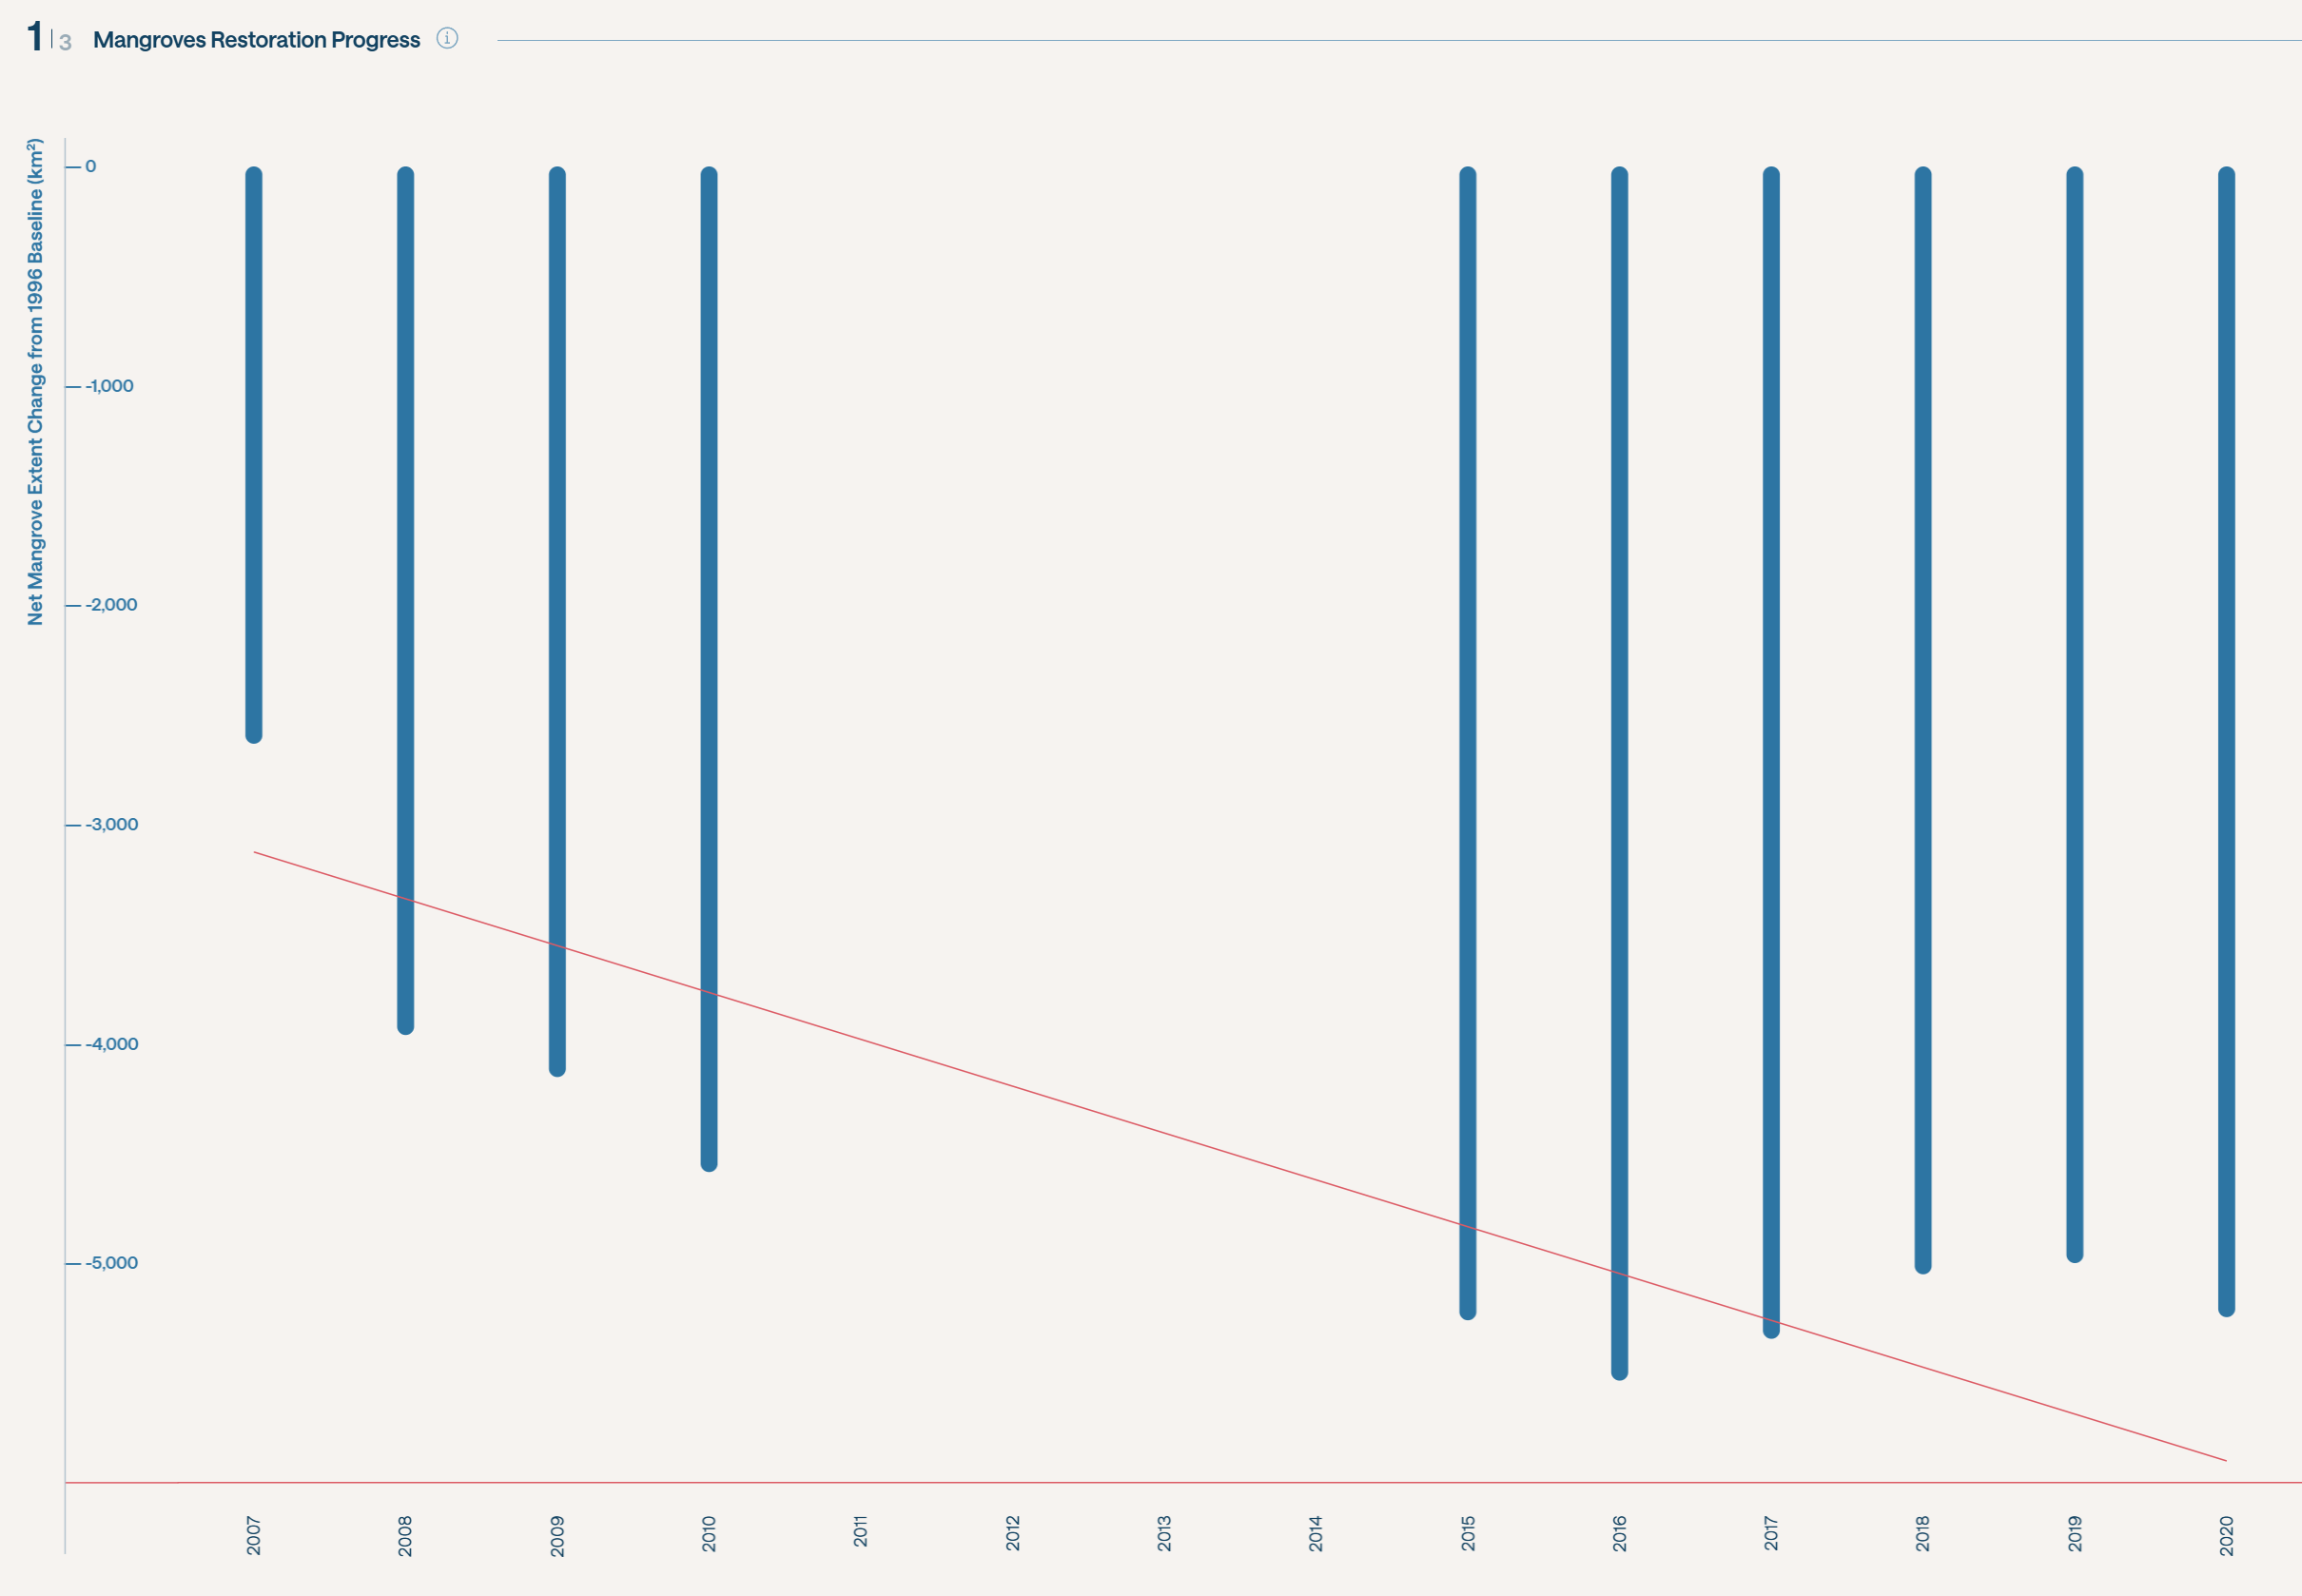

## Ecosystem Restoration Rates (2)

Time series data is currently only available for the mangrove ecosystem.

Data can be found through [Global Mangrove Watch](https://zenodo.org/records/6894273/files/gmw_v3_country_statistics_ha.xlsx?download=1).

This particular chart was generated with the values at the bottom of the `Country Losses from 1996` and `Country Gains from 1996` tabs and calculating the per/year loss from 1996.

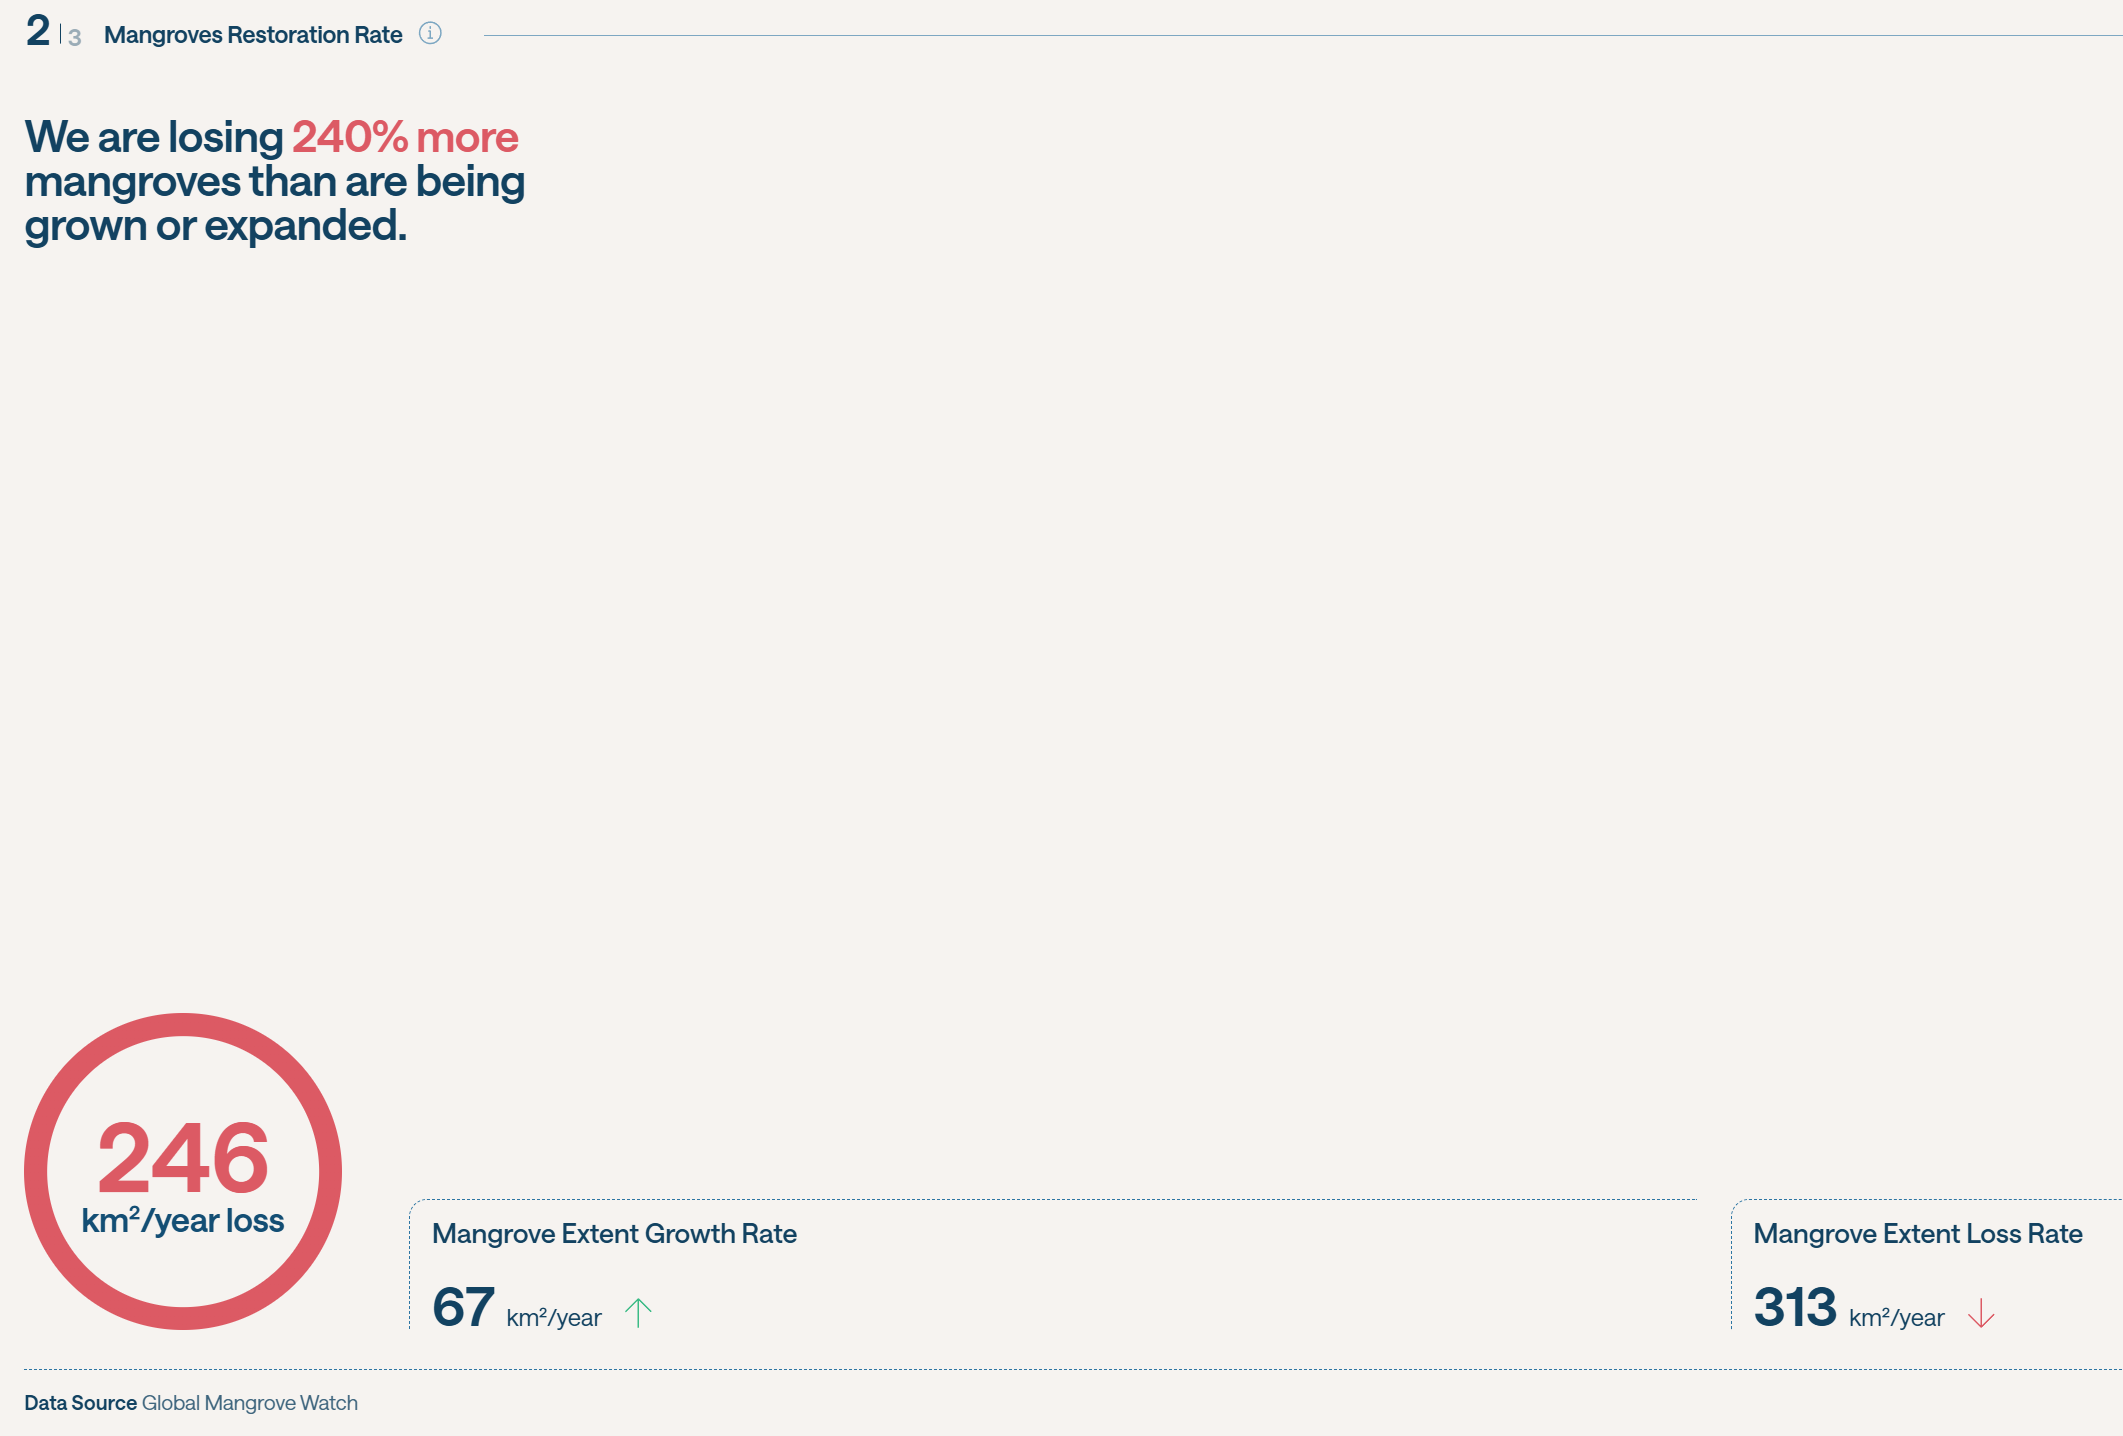

## Ecosystem Coverage by Countries (3)

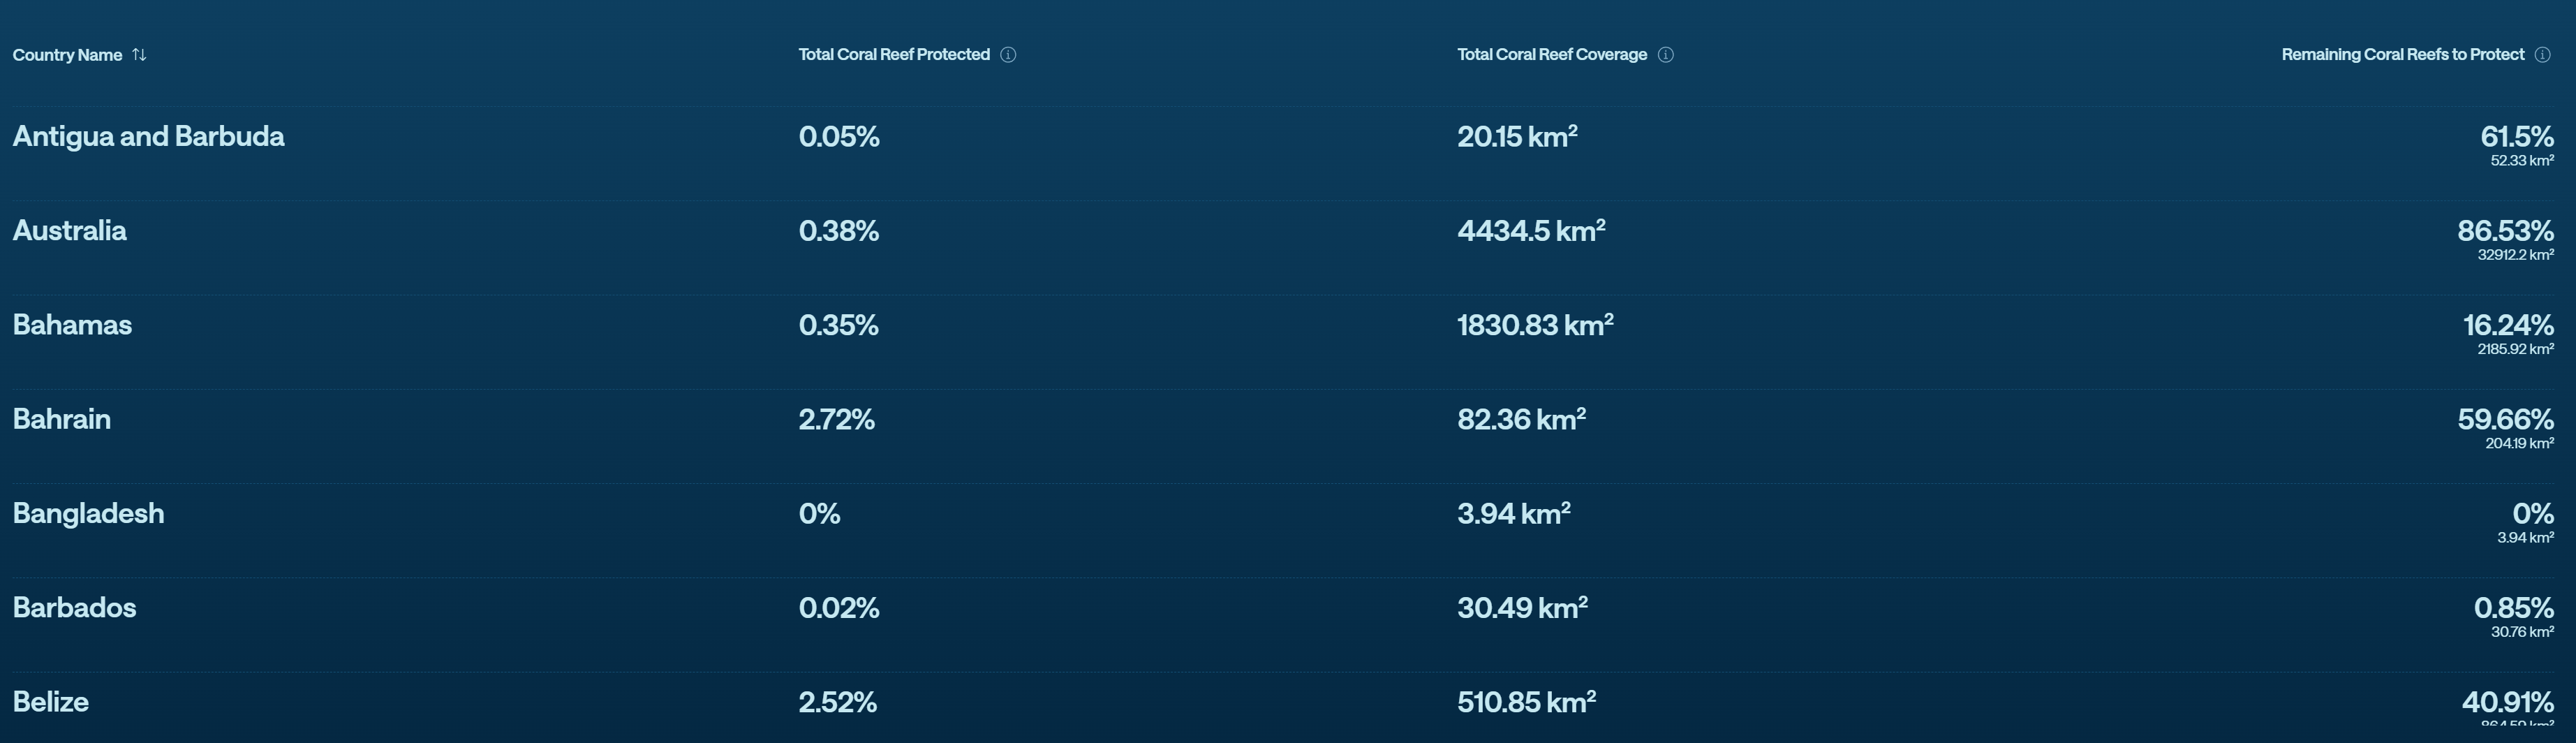

Ecosystem coverage by country was calculated generally by:

1. Intersecting the ecosystem polygons with the polygons of the EEZs
2. Intersecting the above intersection with the polygons of the Marine Protected Areas and OECMs.

We do this in two, slightly different ways. For ecosystems with significant land-based extent we use the UNION of the country shape and the EEZs

In [ ]:
# This cell preprocessed the ecosystem shapefiles by fixing invalid geometries and removing non-polygonal geometries

import geopandas as gpd

ecosystem_filepaths = [
    "data/14_001_WCMC008_CoralReefs2021_v4_1/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp",
    "data/UniAuk-004-ModelledDistributionKelpBiome/01_Data/Kelp UNEP.shp",
    "data/DownloadPack-14_001_ZSL002_ModelledSeamounts2011_v1/01_Data/SeamountsBaseArea/SeamountsBaseArea.shp",
    "data/014_001_WCMC013-014_SeagrassPtPy2021_v7_1/01_Data/WCMC013014-Seagrasses-Py-v7_1.shp",
    "data/global_mangrove_watch/gmw_v3_2020_vec.shp",
    "data/WCMC027_Saltmarsh_v6_1/WCMC027_Saltmarsh_v6_1/01_Data/WCMC027_Saltmarshes_Py_v6_1.shp"]
ecosystem_names = ["coral_reefs", "kelp_forests", "seamounts", "seagrass", "mangroves", "saltmarshes"]

ecosystem_dict = {}

for ecosystem_name, ecosystem_filepath in zip(ecosystem_names, ecosystem_filepaths):
    ecosystem_gdf = gpd.read_file(ecosystem_filepath)
    ecosystem_dict[ecosystem_name] = ecosystem_gdf

for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
    print(f"{ecosystem_name}: {ecosystem_gdf.geometry.is_valid.sum()} valid geometries out of {len(ecosystem_gdf)}")

print("Fixing invalid geometries...")
for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
    ecosystem_gdf.geometry = ecosystem_gdf.geometry.buffer(0)

for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
    print(f"{ecosystem_name}: {ecosystem_gdf.geometry.is_valid.sum()} valid geometries out of {len(ecosystem_gdf)}")

print("Removing non-polygonal geometries...")
for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
    ecosystem_gdf = ecosystem_gdf[ecosystem_gdf.geometry.type.isin(["Polygon", "MultiPolygon"])]
    ecosystem_dict[ecosystem_name] = ecosystem_gdf


# Export each ecosystem to a separate parquet
for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
    ecosystem_gdf.to_parquet(f"./data/{ecosystem_name}_processed.parquet")

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
import numpy as np

# For Mangroves: Flanders Marine Institute (2024). Union of the ESRI Country shapefile and the Exclusive Economic Zones (version 4).

# This function calculates the area of intersection between an EEZ, an ecosystem, and protected areas
# We achieve performant execution by using spatial indices before calling the more expensive geospatial functions
def main():
    # Parse CLI arguments
    # The arguments exist to allow for easier parallel processing
    parser = argparse.ArgumentParser(description='Process EEZs based on start and end percentages.')
    parser.add_argument('start_percentage', type=float, help='Start percentage (between 0 and 100)')
    parser.add_argument('end_percentage', type=float, help='End percentage (between 0 and 100)')
    parser.add_argument('protection_type', type=str, help='Protection type (Total, MPA or OECM)')
    args = parser.parse_args()
    
    start_percentage = args.start_percentage
    end_percentage = args.end_percentage
    protection_type = args.protection_type

    print("Loading data...")
    # These parquet files were pre-processed by:
    # 1. Fixing invalid geometries
    # 2. Dissolving overlapping geometries
    # 3. Keeping protected areas with marine components only
    mpa_gdf = gpd.read_parquet(f"./data/{protection_type}_dissolved_disjoint.parquet")
    
    eez_gdf = gpd.read_file('data/World_EEZ_v12_20231025_gpkg/eez_v12.gpkg')

    if not (0 <= start_percentage <= 100) or not (0 <= end_percentage <= 100):
        raise ValueError("Start and end percentages must be between 0 and 100.")
    if start_percentage >= end_percentage:
        raise ValueError("Start percentage must be less than end percentage.")

    total_eezs = len(eez_gdf)
    start_index = int(start_percentage / 100 * total_eezs)
    end_index = int(end_percentage / 100 * total_eezs)
    eez_gdf = eez_gdf.iloc[start_index:end_index]

    ecosystem_names = ["coral_reefs", "kelp_forests", "seamounts", "seagrass"]
    ecosystem_filepaths = [
        f"./data/{ecosystem_name}_processed.parquet" for ecosystem_name in ecosystem_names
    ]

    print("Loading ecosystem data...")
    ecosystem_dict = {}
    for ecosystem_name, ecosystem_filepath in zip(ecosystem_names, ecosystem_filepaths):
        ecosystem_gdf = gpd.read_parquet(ecosystem_filepath)
        ecosystem_dict[ecosystem_name] = ecosystem_gdf

    INITIAL_CRS = 'ESRI:54009'

    print("Converting data to uniform CRS...")
    print("Before CRS conversion:")
    print("EEZ CRS:", eez_gdf.crs)
    print("MPA CRS:", mpa_gdf.crs)
    for name, gdf in ecosystem_dict.items():
        print(f"{name} CRS:", gdf.crs)

    eez_gdf = eez_gdf.to_crs(INITIAL_CRS)
    mpa_gdf = mpa_gdf.to_crs(INITIAL_CRS)
    ecosystem_dict = {name: gdf.to_crs(INITIAL_CRS) for name, gdf in ecosystem_dict.items()}

    print("\nAfter CRS conversion:")
    print("EEZ CRS:", eez_gdf.crs)
    print("MPA CRS:", mpa_gdf.crs)
    for name, gdf in ecosystem_dict.items():
        print(f"{name} CRS:", gdf.crs)

    # Debug plot to show initial data
    fig, ax = plt.subplots(figsize=(15, 15))
    eez_gdf.boundary.plot(ax=ax, color="blue", label="EEZ", linewidth=2)
    mpa_gdf.plot(ax=ax, color="red", alpha=0.3, label="MPAs")
    ax.set_title("Overview of EEZ and MPAs")
    plt.legend()
    plt.show()

    # Create spatial indices
    print("Creating spatial indices...")
    mpa_sindex = mpa_gdf.sindex
    ecosystem_sindices = {name: gdf.sindex for name, gdf in ecosystem_dict.items()}

    # Debug: Print bounds
    print("\nBounding boxes:")
    print("EEZ bounds:", eez_gdf.total_bounds)
    print("MPA bounds:", mpa_gdf.total_bounds)

    DEBUG = False
    print("Starting data preprocessing...")

    output_dict = {"MRGID": []}
    for ecosystem_name in ecosystem_dict.keys():
        output_dict[f"{ecosystem_name}_area"] = []
        output_dict[f"{ecosystem_name}_protected_area"] = []

    print(f"Processing {len(eez_gdf)} EEZs...")

    for eez_row_index in tqdm(range(len(eez_gdf)), desc="Processing EEZs"):
        eez_row = eez_gdf.iloc[[eez_row_index]]
        mrgid = eez_row.MRGID.values[0]
        output_dict["MRGID"].append(mrgid)
        print(f"\nProcessing EEZ with MRGID: {mrgid}")

        # Get the bounds of the current EEZ
        eez_bounds = eez_row.total_bounds
        print(f"EEZ bounds: {eez_bounds}")

        possible_mpa_matches_idx = list(mpa_sindex.intersection(eez_bounds))
        if possible_mpa_matches_idx:
            possible_mpa_matches = mpa_gdf.iloc[possible_mpa_matches_idx]
        else:
            print("No potential MPA matches found for this EEZ!")

        for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
            print(f"  Analyzing {ecosystem_name}...")
            
            # Use spatial index to find potential intersections
            possible_matches_idx = list(ecosystem_sindices[ecosystem_name].intersection(eez_bounds))
            if possible_matches_idx:
                possible_matches = ecosystem_gdf.iloc[possible_matches_idx]

                ecosystem_intersection = gpd.overlay(eez_row, possible_matches, how="intersection", keep_geom_type=False)
                
                if not ecosystem_intersection.empty:
                    print(f"    Intersection found for {ecosystem_name}")
                    ecosystem_intersection.geometry = ecosystem_intersection.buffer(0)
                    ecosystem_area = ecosystem_intersection.dissolve().area.sum()
                    output_dict[f"{ecosystem_name}_area"].append(ecosystem_area)
                    print(f"    Ecosystem area: {ecosystem_area:.2f} square meters")
                    
                    try:
                        # Use spatial index for MPA intersection
                        possible_mpa_idx = list(mpa_sindex.intersection(ecosystem_intersection.total_bounds))
                        if possible_mpa_idx:
                            possible_mpa_matches = mpa_gdf.iloc[possible_mpa_idx]
                            
                            mpa_intersection = gpd.overlay(
                                possible_mpa_matches, ecosystem_intersection, 
                                how="intersection", keep_geom_type=False
                            )
                            
                            if not mpa_intersection.empty:
                                mpa_intersection.geometry = mpa_intersection.buffer(0)
                                protected_area = mpa_intersection.dissolve().area.sum()
                                print(f"    Protected area: {protected_area:.2f} square meters")

                            else:
                                protected_area = 0
                                print("    No protected area found after overlay")
                            
                            output_dict[f"{ecosystem_name}_protected_area"].append(protected_area)
                        else:
                            output_dict[f"{ecosystem_name}_protected_area"].append(0)
                            print("    No potential MPA intersections found")
                            
                    except NotImplementedError as e:
                        print(f"    Error encountered: {e}")
                        print(f"    Skipping protected area calculation for {ecosystem_name} in EEZ {mrgid}")
                        output_dict[f"{ecosystem_name}_protected_area"].append(np.nan)
                    except Exception as e:
                        print(f"    Unexpected error: {e}")
                        print(f"    Skipping protected area calculation for {ecosystem_name} in EEZ {mrgid}")
                        output_dict[f"{ecosystem_name}_protected_area"].append(np.nan)
                else:
                    print(f"    No actual intersection found for {ecosystem_name}")
                    output_dict[f"{ecosystem_name}_area"].append(0)
                    output_dict[f"{ecosystem_name}_protected_area"].append(0)
            else:
                print(f"    No potential intersections found for {ecosystem_name}")
                output_dict[f"{ecosystem_name}_area"].append(0)
                output_dict[f"{ecosystem_name}_protected_area"].append(0)

        # Save temporary results
        max_length = max(len(output_dict[col]) for col in output_dict)
        for col in output_dict:
            if len(output_dict[col]) < max_length:
                output_dict[col].append(0)
        output_df = pd.DataFrame(output_dict)
        output_df.to_csv(f"restore_ecosystems_{start_percentage}_{end_percentage}_{protection_type}_temp.csv", index=False)

    print("\nProcessing complete. Creating output DataFrame...")
    output_df = pd.DataFrame(output_dict)
    output_df.to_csv(f"restore_ecosystems_{start_percentage}_{end_percentage}_{protection_type}.csv", index=False)
    print("Output DataFrame created.")
    print(f"Total rows in output: {len(output_df)}")
    print("Script execution complete.")

if __name__ == "__main__":
    main()

In [ ]:
# This script is functionally the same as the above, but is meant for those ecosystems with heavy overlap with land.

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
import numpy as np
from glob import glob

# For this script, we use the following file for our country/EEZ areas:
# Flanders Marine Institute (2024). Union of the ESRI Country shapefile and the Exclusive Economic Zones (version 4).

def main():
    # Parse CLI arguments
    parser = argparse.ArgumentParser(description='Process EEZs based on start and end percentages.')
    parser.add_argument('start_percentage', type=float, help='Start percentage (between 0 and 100)')
    parser.add_argument('end_percentage', type=float, help='End percentage (between 0 and 100)')
    parser.add_argument('protection_type', type=str, help='Protection type (Total, MPA or OECM)')
    args = parser.parse_args()
    
    start_percentage = args.start_percentage
    end_percentage = args.end_percentage
    protection_type = args.protection_type

    print("Loading data...")

    mpa_files = glob(f"./data/WDPA_WDOECM_Oct2024_Public_marine_shp/WDPA_WDOECM_Oct2024_Public_marine_shp_*/*polygons.shp")
    mpa_gdf = pd.concat([gpd.read_file(mpa_file) for mpa_file in mpa_files])
    
    # Subsets by protection type TODO
    if protection_type == "mpa":
        mpa_gdf = mpa_gdf[mpa_gdf["PA_DEF"] == "1"]
    elif protection_type == "oecm":
        mpa_gdf = mpa_gdf[mpa_gdf["PA_DEF"] == "0"]

    mpa_gdf = mpa_gdf[mpa_gdf["STATUS"] != "Proposed"]
    
    # Using the union of land and EEZ because Mangroves overlap heavily with the land
    eez_gdf = gpd.read_file('data/EEZ_land_union_v4_202410/EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp')
    eez_gdf = eez_gdf[eez_gdf["MRGID_EEZ"] == 8464]

    if not (0 <= start_percentage <= 100) or not (0 <= end_percentage <= 100):
        raise ValueError("Start and end percentages must be between 0 and 100.")
    if start_percentage >= end_percentage:
        raise ValueError("Start percentage must be less than end percentage.")

    total_eezs = len(eez_gdf)
    start_index = int(start_percentage / 100 * total_eezs)
    end_index = int(end_percentage / 100 * total_eezs)
    eez_gdf = eez_gdf.iloc[start_index:end_index]

    ecosystem_names = ["mangroves", "saltmarshes"]
    ecosystem_filepaths = [
        f"./data/{ecosystem_name}_processed.parquet" for ecosystem_name in ecosystem_names
    ]

    print("Loading ecosystem data...")
    ecosystem_dict = {}
    for ecosystem_name, ecosystem_filepath in zip(ecosystem_names, ecosystem_filepaths):
        ecosystem_gdf = gpd.read_parquet(ecosystem_filepath)
        ecosystem_dict[ecosystem_name] = ecosystem_gdf

    INITIAL_CRS = 'ESRI:54009'

    print("Converting data to uniform CRS...")
    print("Before CRS conversion:")
    print("EEZ CRS:", eez_gdf.crs)
    print("MPA CRS:", mpa_gdf.crs)
    for name, gdf in ecosystem_dict.items():
        print(f"{name} CRS:", gdf.crs)

    eez_gdf = eez_gdf.to_crs(INITIAL_CRS)
    mpa_gdf = mpa_gdf.to_crs(INITIAL_CRS)
    ecosystem_dict = {name: gdf.to_crs(INITIAL_CRS) for name, gdf in ecosystem_dict.items()}

    print("\nAfter CRS conversion:")
    print("EEZ CRS:", eez_gdf.crs)
    print("MPA CRS:", mpa_gdf.crs)
    for name, gdf in ecosystem_dict.items():
        print(f"{name} CRS:", gdf.crs)

    # Debug plot to show initial data
    fig, ax = plt.subplots(figsize=(15, 15))
    eez_gdf.boundary.plot(ax=ax, color="blue", label="EEZ", linewidth=2)
    mpa_gdf.plot(ax=ax, color="red", alpha=0.3, label="MPAs")
    ax.set_title("Overview of EEZ and MPAs")
    plt.legend()
    plt.show()

    # Create spatial indices
    print("Creating spatial indices...")
    mpa_sindex = mpa_gdf.sindex
    ecosystem_sindices = {name: gdf.sindex for name, gdf in ecosystem_dict.items()}

    # Debug: Print bounds
    print("\nBounding boxes:")
    print("EEZ bounds:", eez_gdf.total_bounds)
    print("MPA bounds:", mpa_gdf.total_bounds)

    DEBUG = False
    print("Starting data preprocessing...")

    output_dict = {"MRGID": []}
    for ecosystem_name in ecosystem_dict.keys():
        output_dict[f"{ecosystem_name}_area"] = []
        output_dict[f"{ecosystem_name}_protected_area"] = []

    print(f"Processing {len(eez_gdf)} EEZs...")

    for eez_row_index in tqdm(range(len(eez_gdf)), desc="Processing EEZs"):
        eez_row = eez_gdf.iloc[[eez_row_index]]
        mrgid = eez_row.MRGID_EEZ.values[0]
        output_dict["MRGID"].append(mrgid)
        print(f"\nProcessing EEZ with MRGID: {mrgid}")

        # Get the bounds of the current EEZ
        eez_bounds = eez_row.total_bounds
        print(f"EEZ bounds: {eez_bounds}")

        # Debug: Show potential MPA matches for EEZ
        possible_mpa_matches_idx = list(mpa_sindex.intersection(eez_bounds))
        if possible_mpa_matches_idx:
            possible_mpa_matches = mpa_gdf.iloc[possible_mpa_matches_idx]
        else:
            print("No potential MPA matches found for this EEZ!")

        for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
            print(f"  Analyzing {ecosystem_name}...")
            
            # Use spatial index to find potential intersections
            possible_matches_idx = list(ecosystem_sindices[ecosystem_name].intersection(eez_bounds))
            if possible_matches_idx:
                possible_matches = ecosystem_gdf.iloc[possible_matches_idx]

                ecosystem_intersection = gpd.overlay(eez_row, possible_matches, how="intersection", keep_geom_type=False)
                
                if not ecosystem_intersection.empty:
                    print(f"    Intersection found for {ecosystem_name}")
                    ecosystem_intersection.geometry = ecosystem_intersection.buffer(0)
                    ecosystem_area = ecosystem_intersection.dissolve().area.sum()
                    output_dict[f"{ecosystem_name}_area"].append(ecosystem_area)
                    print(f"    Ecosystem area: {ecosystem_area:.2f} square meters")

                    try:
                        # Use spatial index for MPA intersection
                        possible_mpa_idx = list(mpa_sindex.intersection(ecosystem_intersection.total_bounds))
                        if possible_mpa_idx:
                            possible_mpa_matches = mpa_gdf.iloc[possible_mpa_idx]
                            
                            mpa_intersection = gpd.overlay(
                                possible_mpa_matches, ecosystem_intersection, 
                                how="intersection", keep_geom_type=False
                            )

                            # plot the intersection
                            fig, ax = plt.subplots()
                            eez_row.boundary.plot(ax=ax, color="blue", alpha=0.5)
                            mpa_intersection.plot(ax=ax, color="green", alpha=0.5)
                            ecosystem_intersection.plot(ax=ax, color="red", alpha=0.5)
                            ax.set_title(f"EEZ {mrgid} and {ecosystem_name} intersection")
                            plt.show()
                            
                            if not mpa_intersection.empty:
                                mpa_intersection.geometry = mpa_intersection.buffer(0)
                                protected_area = mpa_intersection.dissolve().area.sum()
                                print(f"    Protected area: {protected_area:.2f} square meters")

                            else:
                                protected_area = 0
                                print("    No protected area found after overlay")
                            
                            output_dict[f"{ecosystem_name}_protected_area"].append(protected_area)
                        else:
                            output_dict[f"{ecosystem_name}_protected_area"].append(0)
                            print("    No potential MPA intersections found")
                            
                    except NotImplementedError as e:
                        print(f"    Error encountered: {e}")
                        print(f"    Skipping protected area calculation for {ecosystem_name} in EEZ {mrgid}")
                        output_dict[f"{ecosystem_name}_protected_area"].append(np.nan)
                    except Exception as e:
                        print(f"    Unexpected error: {e}")
                        print(f"    Skipping protected area calculation for {ecosystem_name} in EEZ {mrgid}")
                        output_dict[f"{ecosystem_name}_protected_area"].append(np.nan)
                else:
                    print(f"    No actual intersection found for {ecosystem_name}")
                    output_dict[f"{ecosystem_name}_area"].append(0)
                    output_dict[f"{ecosystem_name}_protected_area"].append(0)
            else:
                print(f"    No potential intersections found for {ecosystem_name}")
                output_dict[f"{ecosystem_name}_area"].append(0)
                output_dict[f"{ecosystem_name}_protected_area"].append(0)

        # Save temporary results
        max_length = max(len(output_dict[col]) for col in output_dict)
        for col in output_dict:
            if len(output_dict[col]) < max_length:
                output_dict[col].append(0)
        output_df = pd.DataFrame(output_dict)
        output_df.to_csv(f"restore_ecosystems_land_based_{start_percentage}_{end_percentage}_{protection_type}_temp.csv", index=False)

    print("\nProcessing complete. Creating output DataFrame...")
    output_df = pd.DataFrame(output_dict)
    output_df.to_csv(f"restore_ecosystems_land_based_{start_percentage}_{end_percentage}_{protection_type}.csv", index=False)
    print("Output DataFrame created.")
    print(f"Total rows in output: {len(output_df)}")
    print("Script execution complete.")

if __name__ == "__main__":
    main()

The scripts above are still not quite ready for the website yet. We join the MRGID's between the EEZ's and the MPA dataset with the following scripts.

In [ ]:
# If you ran the scripts above with multiple start and end percentages, you can combine the results into a single CSV file using the following script

import pandas as pd
from glob import glob

# Combine all CSV files into a single DataFrame
csv_files = glob("restore_ecosystems_*_temp.csv")

dfs = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

combined_df = pd.concat(dfs)
combined_df = combined_df.drop_duplicates().reset_index(drop=True)

# Save the combined DataFrame to a single CSV file
combined_df.to_csv("restore_ecosystems_combined.csv", index=False)

In [ ]:
files_to_merge = ["restore_ecosystems_combined.csv", "restore_ecosystems_combined_land_based.csv"]